In [3]:
from re import S
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.init as init

import math
import matplotlib.pyplot as plt


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Carga de datos

In [5]:
df = pd.read_csv('close_normalized_prices_index.csv')
# df['X'] = df['X'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
df['Y'] = df['Y'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

In [6]:
df['X'] = df['X'].apply(lambda x:np.fromstring(x.replace('[', '').replace(']', '').replace('\n', ' '), sep=' ').reshape(14, 28))

# Division train-test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df.X.to_numpy()).astype(np.float32),
                                                    np.stack(df.Y.to_numpy()).astype(np.float32),
                                                    test_size=0.30,
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    test_size=0.50,
                                                    random_state=42)

# Conversión a tensores

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 14, 28)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 14, 28)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 14, 28)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Dataloaders

In [9]:
# Crear DataLoaders
batch_size = 100
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modelo

In [11]:
class TransformerForecast(nn.Module):
    def __init__(self, input_size, output_size, num_features, d_model=64, nhead=10, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerForecast, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_features = num_features
        self.d_model = d_model

        # 📌 Capa de Convolución para extraer características locales
        self.conv1_src = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=5, padding=1)  # Conv1d (convolución 1D)
        self.conv2_src = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=4, padding=1)
        self.conv3_src = nn.Conv1d(in_channels=128, out_channels=d_model, kernel_size=3, padding=1)  # Conv final

        self.conv1_tgt = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)  # Conv1d (convolución 1D)
        self.conv2_tgt = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.conv3_tgt = nn.Conv1d(in_channels=128, out_channels=d_model, kernel_size=2, padding=1)  # Conv final

        # 📌 ReLu
        self.relu = nn.ReLU()

        # 📌 Batch Normalization
        self.batch_norm = nn.BatchNorm1d(d_model)  # BatchNorm sobre las salidas de la convolución
        self.batch_norm1 = nn.BatchNorm1d(64) # BatchNorm sobre las salidas de la convolución
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(d_model)  

        # Max Pool
        self.pool = nn.MaxPool1d(kernel_size=2)

        # 📌 Positional Encoding (sin longitud fija, se genera dinámicamente)
        self.pos_encoding = nn.Parameter(torch.randn(input_size, d_model))

        # 📌 Dropout
        self.dropout = nn.Dropout(dropout)

        # 📌 Encoder Transformer
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # 📌 Decoder Transformer
        decoder_layers = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)

        # 📌 Capa Fully Connected para predecir una variable en los 5 pasos futuros
        self.fc = nn.Linear(d_model, output_size)

        # 📌 Inicialización Xavier para las capas lineales
        self._initialize_weights()

    def forward(self, src, tgt=None):
        # 📌 Codificar entrada con embedding
        # src = src.permute(2, 0, 1)
        
        # Inicializamos `tgt` con ceros si no se proporciona (típico en forecasting)
        if tgt is None:
            tgt = torch.zeros(src.shape[0], self.num_features, self.output_size).to(src.device)
        #print(src.shape, tgt.shape)
        #Convolución src
        src = self.conv1_src(src)
        src = self.batch_norm1(src)
        src = self.relu(src)
        src = self.pool(src)

        src = self.conv2_src(src)
        src = self.batch_norm2(src)
        src = self.relu(src)
        src = self.pool(src)

        src = self.conv3_src(src)
        src = self.batch_norm3(src)
        src = self.relu(src)
        src = self.pool(src)

        #Convolución tgt
        tgt = self.conv1_tgt(tgt)
        tgt = self.batch_norm1(tgt)
        tgt = self.relu(tgt)
        tgt = self.pool(tgt)

        tgt = self.conv2_tgt(tgt)
        tgt = self.batch_norm2(tgt)
        tgt = self.relu(tgt)
        tgt = self.pool(tgt)

        tgt = self.conv3_tgt(tgt)
        tgt = self.batch_norm3(tgt)
        tgt = self.relu(tgt)
        tgt = self.pool(tgt)

        # 📌 Aplicar embedding a `src` y `tgt` y añadir el Positional Encoding
        #print("pos encoding", self.pos_encoding.shape)
        pos_encoding_src = self.pos_encoding[:src.size(2), :].permute(1, 0).unsqueeze(0).expand(src.size(0), -1, -1)
        pos_encoding_tgt = self.pos_encoding[:tgt.size(2), :].permute(1, 0).unsqueeze(0).expand(tgt.size(0), -1, -1)
        
        # Aplicar el embedding y el Positional Encoding a `src` y `tgt`
        #print(src.shape, pos_encoding_src.shape)
        src = src + pos_encoding_src
        tgt = tgt + pos_encoding_tgt

        # 📌 Aplicar Batch Normalization y Dropout
        src = self.batch_norm(src)  # BatchNorm requiere (batch, features, seq_len)
        src = self.dropout(src).permute(2, 0, 1)

        tgt = self.batch_norm(tgt)  # BatchNorm requiere (batch, features, seq_len)
        tgt = self.dropout(tgt).permute(2, 0, 1)

        #print(src.shape, tgt.shape)
        # 📌 Pasar por el Transformer Encoder y Decoder
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)

        # 📌 Transformar la salida de forma adecuada
        output = self.fc(output)
        output = output[-1, :, :]  # Tomar la salida del último paso para predecir 5 pasos

        return output

    def _initialize_weights(self):
        # Inicialización Xavier para las capas lineales
        for name, param in self.named_parameters():
            try:
                if 'weight' in name:
                    if 'fc' in name:
                        init.xavier_uniform_(param)  # Xavier para la capa fully connected
                    else:
                        init.xavier_normal_(param)  # Xavier normal para las demás capas lineales
                elif 'bias' in name:
                    init.zeros_(param)  # Inicialización de los bias a cero
            except Exception as e:
                pass

# Función de perdida propia

In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = torch.mean(((y_pred - y_true)*100) ** 2)
        return mse

# Train model

c:\Users\rodri\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/600, Train Loss: 1286.005556, Val Loss: 1396.132504
Epoch 2/600, Train Loss: 1045.735399, Val Loss: 1726.243659
Epoch 3/600, Train Loss: 1022.753133, Val Loss: 1529.380589
Epoch 4/600, Train Loss: 1007.319450, Val Loss: 2260.861226
Epoch 5/600, Train Loss: 993.782622, Val Loss: 2768.133178
Epoch 6/600, Train Loss: 982.302131, Val Loss: 2851.574258
Epoch 7/600, Train Loss: 971.854600, Val Loss: 3656.465345
Epoch 8/600, Train Loss: 962.890033, Val Loss: 2937.160146
Epoch 9/600, Train Loss: 954.245298, Val Loss: 4814.248492
Epoch 10/600, Train Loss: 947.647866, Val Loss: 5362.202293
Epoch 11/600, Train Loss: 940.776950, Val Loss: 3496.369057
Epoch 12/600, Train Loss: 933.132147, Val Loss: 4175.633141
Epoch 13/600, Train Loss: 926.442287, Val Loss: 3421.660657
Epoch 14/600, Train Loss: 921.143089, Val Loss: 3530.995877
Epoch 15/600, Train Loss: 915.374156, Val Loss: 4455.667485
Epoch 16/600, Train Loss: 909.427182, Val Loss: 6217.994788
Epoch 17/600, Train Loss: 905.367537, Val Los

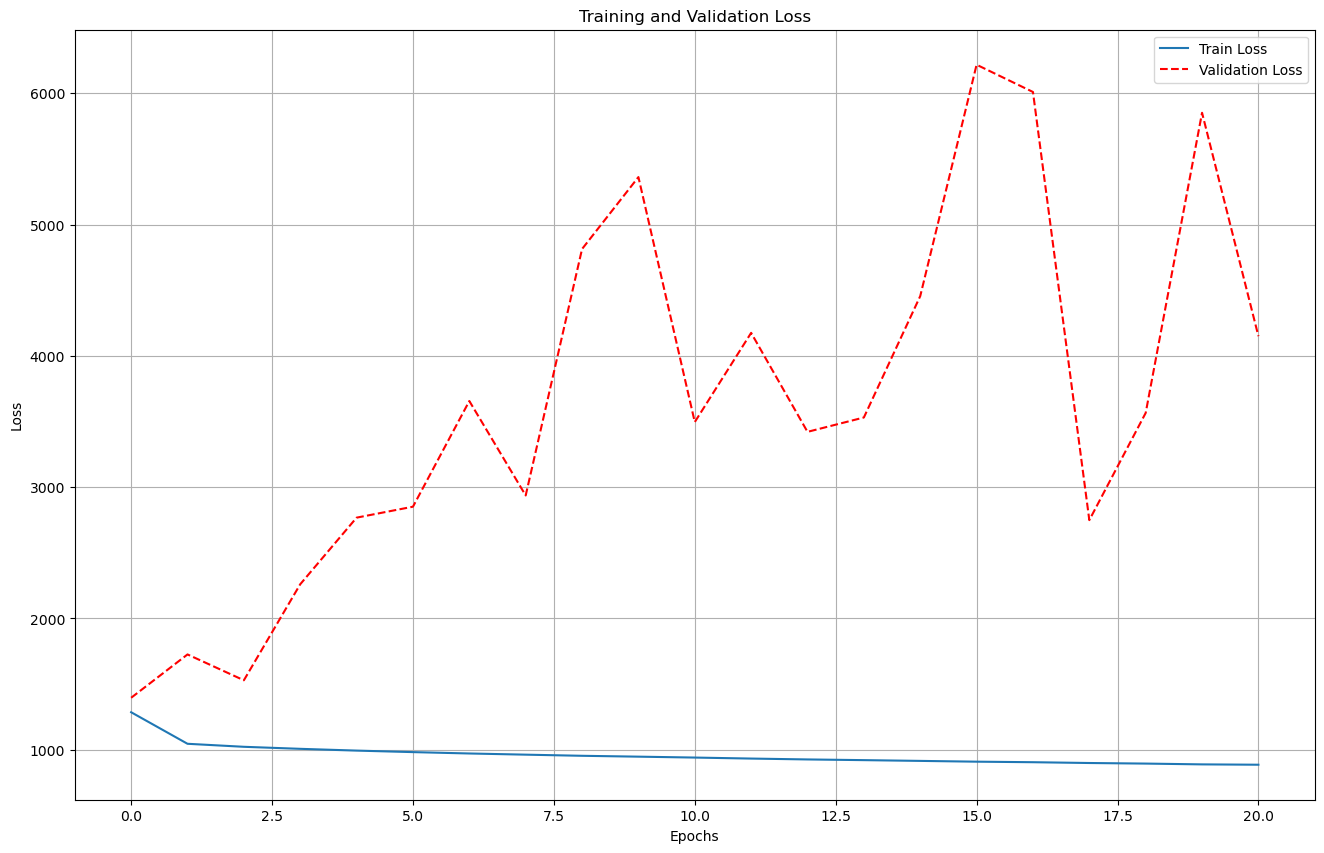

In [13]:
input_size = 28  # Longitud de la secuencia de entrada
output_size = 5  # Número de pasos a predecir
num_features = 14  # Número de características
d_model = 64  # Dimensión del espacio de características
nhead = 4  # Número de cabezas en el mecanismo de atención
num_layers = 5  # Número de capas del transformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerForecast(input_size, output_size, num_features, d_model, nhead, num_layers).to(device)
criterion = CustomLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
epochs = 600
# Parámetros de Early Stopping
patience = 20  # Número de épocas sin mejora antes de detener el entrenamiento
min_delta = 0.05  # Diferencia mínima para considerar una mejora
best_val_loss = float("inf")
counter = 0  # Contador de épocas sin mejora

# Listas para almacenar pérdidas
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluación en el conjunto de validación
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
            total_val_loss += val_loss.item()
    
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # 📌 Early Stopping Logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0  # Reinicia el contador si la validación mejora
        torch.save(model.state_dict(), "best_model.pth")  # Guarda el mejor modelo
    else:
        counter += 1  # Incrementa el contador si no hay mejora
    
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # Detiene el entrenamiento

# 📊 Graficar pérdidas
plt.figure(figsize=(16, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss", linestyle = '--', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid()
plt.show()

In [14]:
model.eval()
predictions = []
actuals = []

# Score en test
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_test = np.concatenate(predictions).reshape(-1, 5)
actuals_test = np.concatenate(actuals).reshape(-1, 5)

# Score en train
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_train = np.concatenate(predictions).reshape(-1, 5)
actuals_train = np.concatenate(actuals).reshape(-1, 5)

# Convertir listas en arrays
predictions_train = np.concatenate(predictions).reshape(-1, 5)
actuals_train = np.concatenate(actuals).reshape(-1, 5)

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_val = np.concatenate(predictions).reshape(-1, 5)
actuals_val = np.concatenate(actuals).reshape(-1, 5)

In [15]:
print("Evaluación del modelo:")
print("MAE Train:", np.mean(np.abs(predictions_train - actuals_train)),
      "MAE Val:", np.mean(np.abs(predictions_val - actuals_val)),
      "MAE Test:", np.mean(np.abs(predictions_test - actuals_test)))
print("MSE Train:", np.mean((predictions_train - actuals_train) ** 2),
      "MSE Val:", np.mean((predictions_val - actuals_val) ** 2),
      "MSE Test:", np.mean((predictions_test - actuals_test) ** 2))
print("RMSE Train:", np.sqrt(np.mean((predictions_train - actuals_train) ** 2)),
      "RMSE Val:", np.sqrt(np.mean((predictions_val - actuals_val) ** 2)),
      "RMSE Test:", np.sqrt(np.mean((predictions_test - actuals_test) ** 2)))

Evaluación del modelo:
MAE Train: 0.47322834 MAE Val: 0.4736848 MAE Test: 0.47652397
MSE Train: 0.40956435 MSE Val: 0.41038612 MSE Test: 0.41609582
RMSE Train: 0.63997215 RMSE Val: 0.64061385 RMSE Test: 0.6450549


**V1 eval (135 epochs)**

NHEAD:4, NUM_LAYERS:3

Evaluación del modelo:

MAE Train: 0.5842637 MAE Test: 0.5855433

MSE Train: 0.54275197 MSE Test: 0.5465877

RMSE Train: 0.73671705 RMSE Test: 0.7393157

**V1 eval (50 epochs)**

Evaluación del modelo:

MAE Train: 0.16892084 MAE Test: 0.20223841

MSE Train: 0.05833414 MSE Test: 0.09049564

RMSE Train: 0.2415246 RMSE Test: 0.30082494

**V1 eval (150 epochs)**

MAE Train: 0.16892084 MAE Test: 0.20223841

MSE Train: 0.05833414 MSE Test: 0.09049564

RMSE Train: 0.2415246 RMSE Test: 0.30082494

In [16]:
torch.save(model.state_dict(), "../weights/transformer_index_v1_weights_1.pth")
torch.save(model, "../models/transformer_index_v1_model_1.pth")